In [1]:
import ssm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import argparse
import pandas as pd
import seaborn as sns
import scipy

/opt/miniconda3/envs/al/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
plt.rc('lines', linewidth=1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.rcParams['font.sans-serif'] = "Helvetica"

cols_glms = ['steelblue', '#D85427', 'tab:green']
# cols_traces = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:purple']
cols_traces = [ '#BE1F24', 'tab:purple', '#fa8072', '#2E3192',]

In [3]:
# Set the parameters of the IO-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make an IO-HMM
true_iohmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.02, 0.03, 0.94]]]))
true_iohmm.observations.params = gen_weights
true_iohmm.transitions.params = gen_log_trans_mat
gen_trans_mat = np.exp(gen_log_trans_mat)[0]

stim_vals = np.arange(-5,5,step=0.01).tolist()
input_list = np.ones((len(stim_vals), input_dim))
input_list[:,0] = stim_vals

num_trials = 1000
init_trials = 100

# Parallel chains for Gibbs sampling, and polyagamma augmentation

## Plotting RMSE

/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

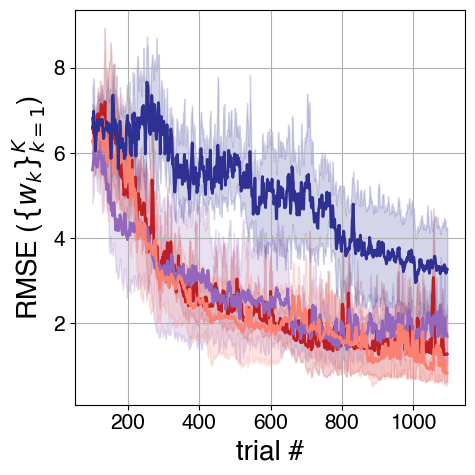

In [4]:
%matplotlib inline

true_weights = np.reshape(gen_weights, (num_states, input_dim))

# Plotting error in weights
num_repeats = 5
error_in_weights=[]

for seed in np.arange(num_repeats):
    error_in_weights_active = np.load("../Results_IOHMM/infomax_gibbs_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_active = np.convolve(error_in_weights_active, np.ones(5)/5, mode='valid') 
    num_trials = error_in_weights_active.shape[0]
    error_in_weights = error_in_weights + error_in_weights_active.tolist()
    
    error_in_weights_parallel = np.load("../Results_IOHMM/infomax_gibbs_parallel_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_parallel = np.convolve(error_in_weights_parallel, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_parallel.tolist()
    
    error_in_weights_pg = np.load("../Results_IOHMM/infomax_gibbs_PG_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_pg = np.convolve(error_in_weights_pg, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_pg.tolist()
    
    error_in_weights_random = np.load("../Results_IOHMM/random_gibbs_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_random = np.convolve(error_in_weights_random, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_random.tolist()

    
sampling_method = (['infomax (single chain)']*num_trials  + ['infomax (5 chains)']*num_trials + ['infomax (PG)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*4*num_repeats
    
weights_list = {"trial #": trials, "Method": sampling_method, "RMSE ($\{w_k\}_{k=1}^K$)": error_in_weights}
df = pd.DataFrame(weights_list, columns = ['trial #', 'Method', 'RMSE ($\{w_k\}_{k=1}^K$)'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="RMSE ($\{w_k\}_{k=1}^K$)", hue="Method", data=df, ax = ax, palette=cols_traces, linewidth=2)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)
ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()
plt.savefig("../Figs_IOHMM/Supp_rmse_weights.png", dpi=400)
plt.savefig("../Figs_IOHMM/Supp_rmse_weights.svg")

/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

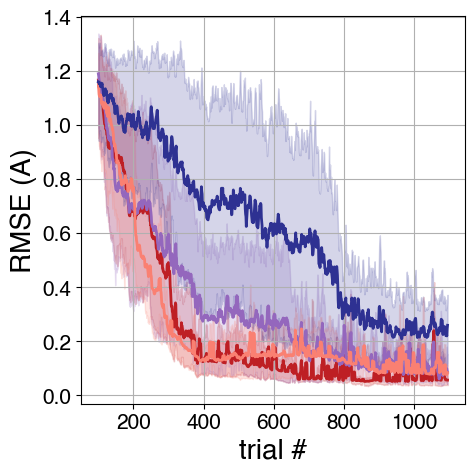

In [5]:
# Plotting error in transition matrix
num_repeats = 5
num_trials = 1000


error_in_Ps = []

for seed in np.arange(num_repeats):
    error_in_Ps_active = np.load("../Results_IOHMM/infomax_gibbs_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_active = np.convolve(error_in_Ps_active, np.ones(5)/5, mode='valid') 
    num_trials = error_in_Ps_active.shape[0]
    error_in_Ps = error_in_Ps + error_in_Ps_active.tolist()
    
    error_in_Ps_parallel = np.load("../Results_IOHMM/infomax_gibbs_parallel_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_parallel = np.convolve(error_in_Ps_parallel, np.ones(5)/5, mode='valid') 
    error_in_Ps = error_in_Ps + error_in_Ps_parallel.tolist()
    
    error_in_Ps_pg = np.load("../Results_IOHMM/infomax_gibbs_PG_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_pg = np.convolve(error_in_Ps_pg, np.ones(5)/5, mode='valid') 
    error_in_Ps = error_in_Ps + error_in_Ps_pg.tolist()
    
    error_in_Ps_random = np.load("../Results_IOHMM/random_gibbs_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_random = np.convolve(error_in_Ps_random, np.ones(5)/5, mode='valid') 
    error_in_Ps = error_in_Ps + error_in_Ps_random.tolist()
    
    
sampling_method = (['infomax (single chain)']*num_trials  + ['infomax (5 chains)']*num_trials + ['infomax (PG)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*4*num_repeats
    

Ps_list = {"trial #": trials, "Method": sampling_method, "RMSE (A)": error_in_Ps}
df = pd.DataFrame(Ps_list, columns = ['trial #', 'Method', 'RMSE (A)'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="RMSE (A)", hue="Method", data=df, ax = ax, palette=cols_traces, linewidth=2)
ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()
plt.savefig("../Figs_IOHMM/Supp_rmse_A.png", dpi=400)
plt.savefig("../Figs_IOHMM/Supp_rmse_A.svg")